<a href="https://colab.research.google.com/github/ashikshafi08/PawPularity_Kaggle/blob/main/Pawpularity_TensorFlow_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pawpularity TensorFlow Implementation
This notebook will contain the TensorFlow code for the PawPularity Competition, previously we got ourselves into Top 100 with the help of Fastai but now I want to see how far I can go with TensorFlow. 

I am going to try the following things, 
- Use model subclassing when in need 
- Try out vision transformer 
- Try out EANet (this replaces the self attention) 
- 

## Getting the data ready 

In [ ]:
# Importing the google drive 
from google.colab import drive
drive._mount('/content/drive')
# Importing the needed packages 
import tensorflow as tf 
import tensorflow_hub as hub 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from tensorflow.keras import layers 

# Installing tensorlfow addons 
!pip install tensorflow_addons 
import tensorflow_addons as tfa

Mounted at /content/drive
     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [ ]:
# Specifying the data paths 
train_image_path = '/content/drive/MyDrive/Kaggle_Competition/petfinder-pawpularity-score/train/'
test_image_path = '/content/drive/MyDrive/Kaggle_Competition/petfinder-pawpularity-score/test/'

train_df_path = '/content/drive/MyDrive/Kaggle_Competition/petfinder-pawpularity-score/train.csv'
test_df_path = '/content/drive/MyDrive/Kaggle_Competition/petfinder-pawpularity-score/test.csv'
sample_sub_path = '/content/drive/MyDrive/Kaggle_Competition/petfinder-pawpularity-score/sample_submission.csv'


# Loading in the data paths 


train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)
sample_sub_df = pd.read_csv(sample_sub_path)

train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [ ]:
# Append the full path 
def append_ext(fn , train = True):
  if train:
    return f'{train_image_path}{fn}.jpg'
  else:
    return f'{test_image_path}{fn}.jpg'

# Applying the above function on our dataframe 
train_df['full_path'] = train_df['Id'].apply(lambda x: append_ext(x))
test_df['full_path'] = test_df['Id'].apply(lambda x: append_ext(x , train = False))

train_df.head(10)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,full_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/content/drive/MyDrive/Kaggle_Competition/petf...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/content/drive/MyDrive/Kaggle_Competition/petf...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/content/drive/MyDrive/Kaggle_Competition/petf...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/content/drive/MyDrive/Kaggle_Competition/petf...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/content/drive/MyDrive/Kaggle_Competition/petf...
5,001dd4f6fafb890610b1635f967ea081,0,0,1,0,0,0,0,0,0,0,0,1,74,/content/drive/MyDrive/Kaggle_Competition/petf...
6,0023b8a3abc93c712edd6120867deb53,0,1,1,1,0,0,0,0,1,1,0,0,22,/content/drive/MyDrive/Kaggle_Competition/petf...
7,0031d6a9ef7340f898c3e05f92c7bb04,0,1,1,0,0,0,1,1,0,0,1,0,35,/content/drive/MyDrive/Kaggle_Competition/petf...
8,0042bc5bada6d1cf8951f8f9f0d399fa,0,1,1,1,0,0,0,0,0,0,0,0,53,/content/drive/MyDrive/Kaggle_Competition/petf...
9,0049cb81313c94fa007286e9039af910,0,1,1,1,0,0,0,0,0,0,0,0,21,/content/drive/MyDrive/Kaggle_Competition/petf...


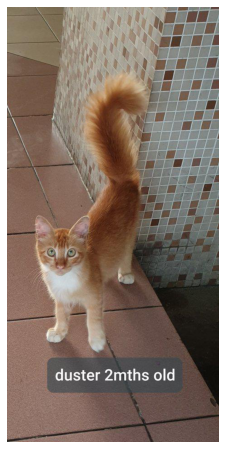

In [ ]:
# Displaying random images of pets 
import matplotlib.image as mpimg 
import random 
from matplotlib.pyplot import figure 
random_index = random.randrange(len(train_df['full_path'].tolist())) 

train_fns = train_df['full_path'].tolist()
train_labels = train_df['Pawpularity'].to_list()


random_filename = train_fns[random_index]
random_label = train_labels[random_index]

# Plotting the image 
im = mpimg.imread(random_filename)
figure(figsize = (10 , 8))
plt.imshow(im)
plt.axis('off');

In [ ]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,full_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/content/drive/MyDrive/Kaggle_Competition/petf...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/content/drive/MyDrive/Kaggle_Competition/petf...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/content/drive/MyDrive/Kaggle_Competition/petf...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/content/drive/MyDrive/Kaggle_Competition/petf...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/content/drive/MyDrive/Kaggle_Competition/petf...


##1. Own Flavours of Multi-modal model (positional encoding)

Things to do: 
- Use the EfficientNetB0 as the image feature extractor
- Make use of the other features as positional encoding. 
- See if there should be used differente losses (classification + regression) 

In [ ]:
# Getting the EfficientNetB0 base model 
input_shape = (224 , 224 ,3)
#base_model = tf.keras.applications.EfficientNetB0(include_top= False)

# Freeze the base model layers 
#base_model.trainable = False 


In [ ]:
def augment_data(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_saturation(img , 0.95 , 1.05)
    img = tf.image.random_brightness(img , 0.5)
    img = tf.image.random_contrast(img , 0.95 , 1.05)
    img = tf.image.random_hue(img , 0.05)
    
    return img



# Get the image data 
def load_img(file_path , label):
  im = tf.io.read_file(file_path)
  im = tf.image.decode_jpeg(im , channels = 3)
  im = tf.image.convert_image_dtype(im , tf.float32)
  im = tf.image.resize(im , size = (224 , 224))
 # im = im / 255. # turns the whole image into black
  im = augment_data(im)
  return im , label

Building the model with the following features, 
- Subject Focus (one hot encoded)
- Eyes (one hot encoded) 
- Human (one hot encoded) 
- Pawpularity (the label itself) 
- full_path (locate the images) 

In [ ]:
# Buildin the model (no idea)

# Getting the image data 
img_inputs = layers.Input(shape = input_shape , name = 'Input layer')


In [ ]:
# Building Image Feature Vector 
def image_feature_vector(input_shape , units):

  inputs = layers.Input(shape = input_shape , name = 'Input layer')
  x = base_model(inputs , training = False)
  x = layers.GlobalAveragePooling2D(name = 'pooling_layer')(x)
  x = layers.Dense(units , activation= 'relu')(x)

  # Packing into a feature vector model 
  feat_model = tf.keras.Model(inputs , x)
  return feat_model


Whats next? 

We got the image feature vector which has the image representation as a vector, the next thing will be trying to tweak in the one hot encoding features and see if they can increase the performance of the model. 

This is going to be bit tricky tho.


```
img_feature vector -> eyes feat vector -> rest all the feature vector -> concatenate the all the outputs -> some more additional layers on top of the feature vectors -> dropout -> output layer (linear tho) -> Pack into a model 


```


- Image Embedding: This takes in the image, apply the EfficientNet model to our images, gives out the embeddings. 
- PositionalEmbedding: Takes in a one hot encoded and apply dense layer on it, returns back the embeddings. 



[Multi-Input and output in Subclassing](https://stackoverflow.com/questions/59743161/tensorflow-model-subclassing-mutli-input)

In [ ]:
len(train_df.Pawpularity)

9912

In [ ]:
class ImageEmbedding(tf.keras.layers.Layer):

  def __init__(self , units, activation , shape , **kwargs):
    super(ImageEmbedding , self).__init__(**kwargs)

    self.units = units 
    self.activation = activation

    self.inp_layer = layers.Input(shape = input_shape , name = 'input_layer')
    self.base_model = tf.keras.applications.EfficientNetB0(include_top= False)
    self.dense = tf.keras.layers.Dense(units = units , activation = activation , name = 'simple_dense_layer')
    self.pooling_layer = layers.GlobalMaxPooling2D()

  def call(self , inputs):
    self.base_model.trainable = False 
    img = inputs[0] # image tensor
    label = inputs[1] # label
    x = self.base_model(img , training = False)
    x = self.pooling_layer(x)
    x = self.dense(x)
    return x ,label


In [ ]:
im = ImageEmbedding(32 , activation= 'relu' , shape = (224 , 224 , 3))
im

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
sample_img = load_img(random_filename, random_label)
# Just getting the image
layers.Dense(32 , activation = 'relu')(im(sample_img)[0])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[4.4436216 , 0.        , 3.053551  , 0.        , 0.        ,
        4.094793  , 0.        , 3.9108403 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 3.068644  , 4.984922  ,
        4.26949   , 0.        , 0.        , 6.066822  , 0.        ,
        0.        , 0.        , 0.        , 0.        , 5.050349  ,
        2.0488374 , 1.7391028 , 0.        , 0.        , 3.8850965 ,
        5.8861947 , 0.05609845]], dtype=float32)>

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    
    def __init__(self , units , activation , **kwargs):
        super(PositionalEmbedding , self).__init__(**kwargs)

        self.units = units 
        self.activation = activation 

        self.dense = layers.Dense(units , activation , name = 'dense_layer')

    def call(self, inputs):
        x = self.dense(inputs)
        return x 

In [ ]:
# Testing out the above layer
l = PositionalEmbedding(32 , 'relu')
m = tf.one_hot(train_df['Blur'].to_numpy() , depth= 1)
l(m)

<tf.Tensor: shape=(9912, 32), dtype=float32, numpy=
array([[0.00614282, 0.        , 0.        , ..., 0.        , 0.13207012,
        0.35174382],
       [0.00614282, 0.        , 0.        , ..., 0.        , 0.13207012,
        0.35174382],
       [0.00614282, 0.        , 0.        , ..., 0.        , 0.13207012,
        0.35174382],
       ...,
       [0.00614282, 0.        , 0.        , ..., 0.        , 0.13207012,
        0.35174382],
       [0.00614282, 0.        , 0.        , ..., 0.        , 0.13207012,
        0.35174382],
       [0.00614282, 0.        , 0.        , ..., 0.        , 0.13207012,
        0.35174382]], dtype=float32)>

In [ ]:
# Converting the other features into one hot encoded representation 
def one_hot_conversion(col_list):
    one_hot = tf.one_hot(col_list, depth = 1 , dtype = tf.int32)
    return one_hot

# Converting only 4 columns for now
eyes_one_hot = one_hot_conversion(train_df.Eyes.tolist())
face_one_hot = one_hot_conversion(train_df.Face.tolist())
near_one_hot = one_hot_conversion(train_df.Near.tolist())
group_one_hot = one_hot_conversion(train_df.Group.tolist())

Using the above layers and combining into a full feledged model! 



In [ ]:
# # Data Augmentation layers 
# from tensorflow.keras.layers.experimental import preprocessing

# data_augmentation = tf.keras.Sequential([
#     preprocessing.RandomFlip('horizontal'), 
#     preprocessing.RandomZoom(0.2), 
#     preprocessing.RandomRotation(0.3), 
#     preprocessing.RandomHeight(0.4), 
#     preprocessing.RandomWidth(0.4)
# ], name ='data_augmentation')

# After the new tf version update, using data augmentation throws error. 

In [ ]:
eyes_one_hot[0]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>

In [ ]:
image_embed = ImageEmbedding(32 , activation= 'relu' , shape = (224 , 224 , 3))
positional_layer = PositionalEmbedding(32 , 'relu')

In [ ]:
# Building the model 

# Image inputs
input = layers.Input(shape = (224 , 224 , 3))
image_embedding = image_embed(input)
image_embed_model = tf.keras.Model(input , image_embedding)


# Eyes inputs 
eyes_input = layers.Input(shape = (1,), dtype = tf.int32)
eyes_pos_embed = positional_layer(eyes_input)
eyes_output = layers.Dense(32, name = 'eyes_feature')(eyes_pos_embed)
eyes_embed_model = tf.keras.Model(eyes_input , eyes_output)


# Face inputs 
face_input = layers.Input(shape = (1,), dtype = tf.int32)
face_pos_embed = positional_layer(face_input)
face_output = layers.Dense(32 , name = 'face_feature')(face_pos_embed)
face_embed_model = tf.keras.Model(face_input , face_output)

# Combining the inputs 





In [ ]:
* eyes 
* face 
* near 
* group 


# The Plan 

* Concatenate the inputs 
* Different loss functions for different types of inputs (define them via name)

## Different Experiments 

### Experiment Number 1 

Using a simple CNN without any complications.

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(include_top = False)
base_model.trainable = False 


# Set up the model with other following layers 
inputs = layers.Input(shape = (224 ,224 , 3) , name = 'input_layer')
x = base_model(inputs , training = False)
x = layers.GlobalAveragePooling2D(name = 'pool_layer')(x)
x = layers.Flatten()(x)
x = layers.Dense(256 , activation = 'relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs , outputs)

model.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 pool_layer (GlobalAveragePo  (None, 1536)             0         
 oling2D)                                                        
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0      

In [ ]:
# Making tf dataset 
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
targ_scaled = scaler.fit_transform(tf.expand_dims(train_df.Pawpularity , axis = 1)) 

train_filenames = tf.data.Dataset.from_tensor_slices(train_df.full_path)
train_paw_scores = tf.data.Dataset.from_tensor_slices(targ_scaled)


# Compiling into a dataset 
train_ds = tf.data.Dataset.zip((train_filenames , train_paw_scores))

train_ds = train_ds.map(map_func = load_img , num_parallel_calls= tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size = 1000).batch(64).prefetch(buffer_size = tf.data.AUTOTUNE)

train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float64)>

In [ ]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,full_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/content/drive/MyDrive/Kaggle_Competition/petf...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/content/drive/MyDrive/Kaggle_Competition/petf...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/content/drive/MyDrive/Kaggle_Competition/petf...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/content/drive/MyDrive/Kaggle_Competition/petf...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/content/drive/MyDrive/Kaggle_Competition/petf...


In [ ]:
# Compiling the model 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),  
              optimizer = tf.keras.optimizers.Adam() , 
              metrics = [tf.keras.metrics.RootMeanSquaredError()])

# Fitting the model 
model.fit(train_ds , 
          epochs = 3)

Epoch 1/3
155/155 [==============================] - 300s 790ms/step - loss: 9.5195 - root_mean_squared_error: 8.1786
Epoch 2/3
155/155 [==============================] - 134s 788ms/step - loss: 9.5440 - root_mean_squared_error: 8.5802
Epoch 3/3
155/155 [==============================] - 133s 783ms/step - loss: 9.5440 - root_mean_squared_error: 8.5628


In [ ]:
# Setting all layers to trainable 
for layer in model.layers:
    layer.trainable = True 
    print(layer.name , layer.trainable)

input_layer True
efficientnetb3 True
pool_layer True
flatten True
dense True
dropout True
dense_1 True


In [ ]:
# Test Dataset 

def test_load_img(file_path):
  im = tf.io.read_file(file_path)
  im = tf.image.decode_jpeg(im , channels = 3)
  im = tf.image.convert_image_dtype(im , tf.float32)
  im = tf.image.resize(im , size = (224 , 224))
  im = augment_data(im)
 # im = im / 255. # turns the whole image into black
  return im 

test_ds = tf.data.Dataset.from_tensor_slices(test_df.full_path)
test_ds = test_ds.map(map_func = test_load_img , num_parallel_calls= tf.data.AUTOTUNE)
test_ds = test_ds.batch(32)

test_ds

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
preds = model.predict(test_ds , use_multiprocessing= True)
preds

array([[0.39199415],
       [0.39021626],
       [0.39041877],
       [0.39135686],
       [0.39478454],
       [0.39353696],
       [0.39419287],
       [0.3919762 ]], dtype=float32)

In [ ]:
scaler.inverse_transform(preds)

array([[39.807423],
       [39.631413],
       [39.65146 ],
       [39.74433 ],
       [40.08367 ],
       [39.96016 ],
       [40.025097],
       [39.805645]], dtype=float32)

In [ ]:
submission = pd.DataFrame({'Id': test_df.Id , 
                           'Pawpularity': tf.squeeze(scaler.inverse_transform(preds))})

submission.to_csv('submission.csv' , index = False)


In [ ]:
submission

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,39.807423
1,43a2262d7738e3d420d453815151079e,39.631413
2,4e429cead1848a298432a0acad014c9d,39.651459
3,80bc3ccafcc51b66303c2c263aa38486,39.744331
4,8f49844c382931444e68dffbe20228f4,40.083672
5,b03f7041962238a7c9d6537e22f9b017,39.960159
6,c978013571258ed6d4637f6e8cc9d6a3,40.025097
7,e0de453c1bffc20c22b072b34b54e50f,39.805645


In [ ]:
model.save('simple_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
new = tf.keras.models.load_model('simple_model.h5')
new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 pool_layer (GlobalAveragePo  (None, 1280)             0         
 oling2D)                                                        
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             